In [3]:
%load_ext autoreload
%autoreload 2

import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

sns.set_style('whitegrid')

sys.path.append("../")
from utility.ar1 import AR1
from utility.ar import AR

### AR(1) on different initial value

<AxesSubplot: >

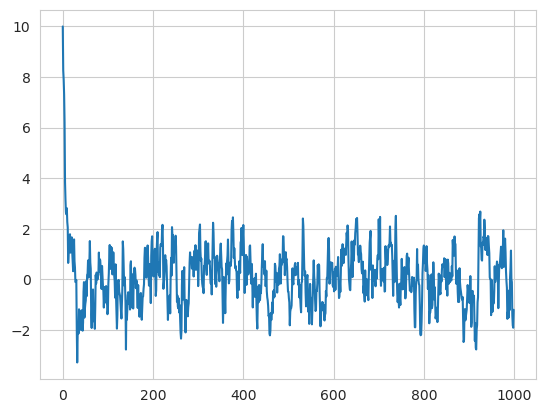

In [19]:
s = 1
phi = 0.8
ar = AR1(phi=phi, var=s*(1-phi**2))
ar.simulate(x0=10, length=1000).plot()

<AxesSubplot: >

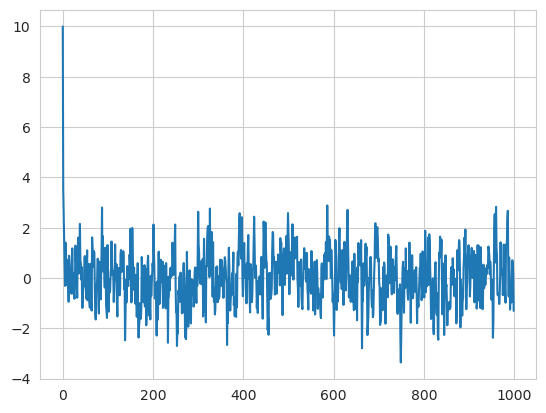

In [20]:
s = 1
phi = 0.5
ar = AR1(phi=phi, var=s*(1-phi**2))
ar.simulate(x0=10, length=1000).plot()

<AxesSubplot: >

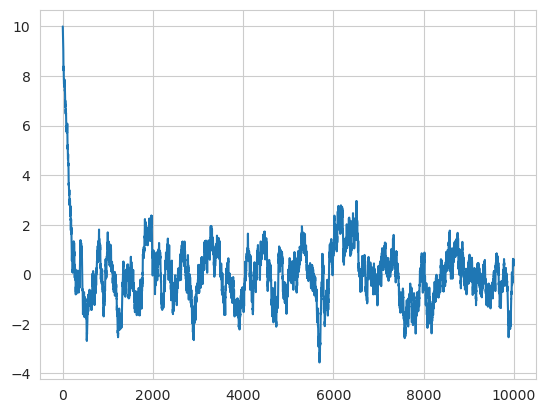

In [22]:
s = 1
phi = 0.99
ar = AR1(phi=phi, var=s*(1-phi**2))
ar.simulate(x0=10, length=10000).plot()

### AR(1) & KL Divergence from Stationary

Both higher $x_0$ and higher $\phi$ slows down the chain convergence to the stationary distribution.
And negative $\phi$ doesn't seems to help with convergence, either.

In [4]:
def kl_gp(k, x0, phi, var):
    """How far the current process is from stationary distribution after k-step started at x0 point"""
    vr = var * (1-phi**(2*k)) / (1-phi**2)
    return 1/2 * (np.log(1-phi**(2*k)) - 1 + 1/(1-phi**(2*k))) + (phi**(2*k) * x0**2) / (2 * vr)

def kl_pg(k, x0, phi, var):
    """How far the stationary is from k-step current process started at x0 point"""
    vr = var * (1-phi**(2*k)) / (1-phi**2)
    s = var / (1-phi**2)
    return 1/2 * (np.log(1/(1-phi**(2*k))) - 1 + vr/s) + (phi**(2*k) * x0**2) / (2 * s)

def kl_asymp(k, x0, phi, var):
    s = var / (1-phi**2)
    return (phi**(2*k) * x0**2) / (2*s)

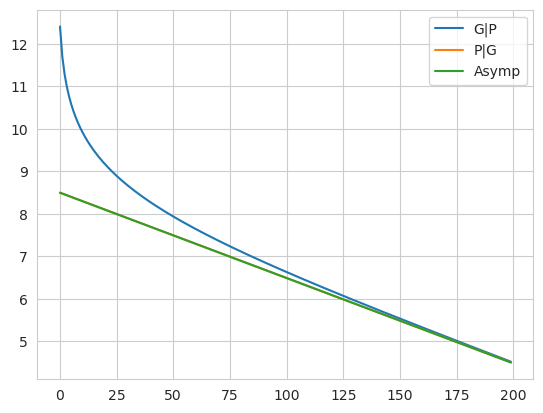

In [32]:
x0 = 100
phi = -0.99
s = 1
v = s * (1-phi**2)
ks = np.arange(200)+1

plt.plot(np.log(kl_gp(ks, x0, phi, v)), label='G|P')
plt.plot(np.log(kl_pg(ks, x0, phi, v)), label='P|G')
plt.plot(np.log(kl_asymp(ks, x0, phi, v)), label='Asymp')

plt.legend()
plt.show()

### AR(1) with Student-T innovation

Student-T is a scale-mixture of normal. If we replaced the orignal Gaussian noise with a T-distribution with k-degree of freedom, the AR(1) process would starts to look more spiky with lower the k. As $k \rightarrow \infty$, the process converge to the Gaussian AR(1) process.
- First Order Markov? Yes, the markovian property doesn't depdens on the error structure.
- Stationary Process? Yes, the stationary distribution $p(x)$ should also be a t-distribution, which follows directly from that the student-t is a scale-mixture of normal.
- Linear Process? Yes. It is obvious. AR(1) is a linear process.
- Time reversible? Yes, both the joint and marginal are the same and exchangable.

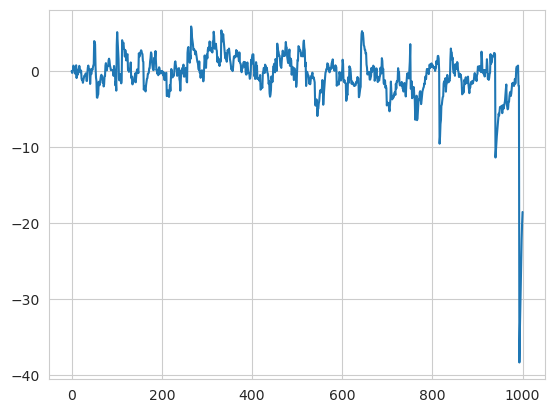

In [172]:
def gen_t_samples(df, loc, scale, size=1):
    x2s = np.random.gamma(df/2, scale=2/df, size=size)
    ts = np.random.normal(loc=loc, scale=1/np.sqrt(x2s))
    return np.sqrt(scale) * ts

phi = 0.9
s = 1
v = s * (1-phi**2)
k = 2
x0 = 0

# list of normal random for the future
x = x0
trace = [x]
for t in gen_t_samples(k, 0, v, size=1000):
    x = phi * x + t
    trace.append(x)

plt.plot(trace)

<AxesSubplot: >

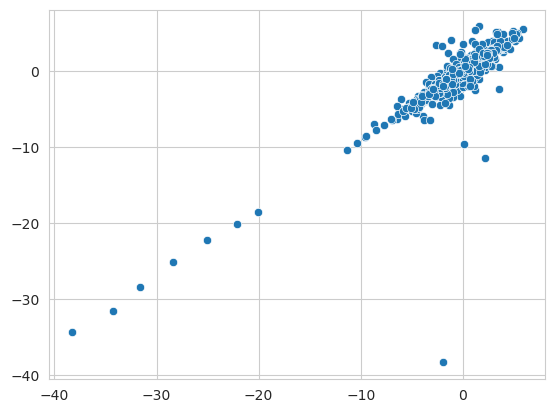

In [173]:
sns.scatterplot(x=trace[:-1], y=trace[1:])